In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'used-cars-price-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F983987%2F1661940%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240622%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240622T082532Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8dcf3c312125b1edb966c31e64fec4cce3297254536f2b53c3f81931a0d4fdc7749b21948c312c905a722b751e611dacc14cce689d75aea38115949e1175729867aef263879452af13098850f1872cdfad1b738248cf33242f15dca73a8bce2b884e6acfdb5f28195b2a4ba728b1319acdfc4afae3224d7e058bd850eba7b8f24154ab88450794bf72b441edfd19ba5769c1e522ebf060f1c3f8d50252c7b70c8209579a49538f0f660799a8e7a2dfa8915d3a63234ece3e10d13797f587bb3c3e50426f0cd79f86efe5cd7372fa9e627113b247d160878a71d9e3c25138dc5eb8c17066c1ddff0bb59e663d2312e88adcf67be61784de75bb1108d7f343dc50'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 160105 bytes downloaded
Downloaded and uncompressed: used-cars-price-prediction
Data source import complete.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
sns.set(rc={'figure.figsize': [10, 10]}, font_scale=1.2)

# Cars Analysis and Predict Price with acc 93%

# import Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score ,mean_squared_error

#### Data

In [5]:
data = pd.read_csv(r"train.csv")
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


# Dictionry of Data

     Attribute	Description
     Name	The brand and model of the car
     Location	The location in which the car is being sold or is available for purchase
     Year	The year or edition of the model
     Kilometers_Driven	The total kilometers driven in the car by the previous owner(s) in KM
     Fuel_Type	The type of fuel used by the car
     Transmission	The type of transmission used by the car
     Owner_Type	Whether the ownership is Firsthand, Second hand or other
     Mileage	The standard mileage offered by the car company in kmpl or km/kg
     Engine	The displacement volume of the engine in cc
     Power	The maximum power of the engine in bhp
     Seats	The number of seats in the car
     New_Price	Price of new model
     Price	The price of the used car in INR Lakhs

# Data Cleaning


In [7]:
data.duplicated().sum()

0

In [8]:
data.isna().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

> drop colum "New_Price"


beacuse have more than 50% nan value

In [9]:
data.drop("New_Price" ,axis=1 ,inplace =True)

In [10]:
data.Name

0                 Maruti Wagon R LXI CNG
1       Hyundai Creta 1.6 CRDi SX Option
2                           Honda Jazz V
3                      Maruti Ertiga VDI
4        Audi A4 New 2.0 TDI Multitronic
                      ...               
6014                    Maruti Swift VDI
6015            Hyundai Xcent 1.1 CRDi S
6016               Mahindra Xylo D4 BSIV
6017                  Maruti Wagon R VXI
6018               Chevrolet Beat Diesel
Name: Name, Length: 6019, dtype: object

In [11]:
data.Name = data.Name.apply(lambda x :" ".join(x.split()[0:2]))

In [12]:
data.Name.nunique()

216

In [13]:
data.sample()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
395,Maruti Ritz,Coimbatore,2011,90207,Diesel,Manual,First,21.1 kmpl,1248 CC,73.9 bhp,5.0,3.91


> Mileage

In [14]:
data.Mileage.value_counts()

Mileage
18.9 kmpl     172
17.0 kmpl     172
18.6 kmpl     119
20.36 kmpl     88
21.1 kmpl      86
             ... 
27.28 kmpl      1
14.57 kmpl      1
22.8 km/kg      1
8.0 kmpl        1
17.24 kmpl      1
Name: count, Length: 442, dtype: int64

> note

     there are null value

In [15]:
data.Mileage.isna().sum()

2

In [16]:
data.drop(data[data.Mileage.isna()].index, inplace =True)

> remember

      Power have nan value

In [17]:
index= data[data.Power.isna()].index
data[data.Power.isna()]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
194,Honda City,Ahmedabad,2007,60006,Petrol,Manual,First,0.0 kmpl,NaN,NaN,NaN,2.95
208,Maruti Swift,Kolkata,2010,42001,Petrol,Manual,First,16.1 kmpl,NaN,NaN,NaN,2.11
733,Maruti Swift,Chennai,2006,97800,Petrol,Manual,Third,16.1 kmpl,NaN,NaN,NaN,1.75
749,Land Rover,Mumbai,2008,55001,Diesel,Automatic,Second,0.0 kmpl,NaN,NaN,NaN,26.50
1294,Honda City,Delhi,2009,55005,Petrol,Manual,First,12.8 kmpl,NaN,NaN,NaN,3.20
1327,Maruti Swift,Hyderabad,2015,50295,Petrol,Manual,First,16.1 kmpl,NaN,NaN,NaN,5.80
1385,Honda City,Pune,2004,115000,Petrol,Manual,Second,0.0 kmpl,NaN,NaN,NaN,1.50
1460,Land Rover,Coimbatore,2008,69078,Petrol,Manual,First,0.0 kmpl,NaN,NaN,NaN,40.88
2074,Maruti Swift,Pune,2011,24255,Petrol,Manual,First,16.1 kmpl,NaN,NaN,NaN,3.15
2096,Hyundai Santro,Coimbatore,2004,52146,Petrol,Manual,First,0.0 kmpl,NaN,NaN,NaN,1.93


In [18]:
data.drop(index ,inplace =True)

In [19]:
data.isna().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                6
Price                0
dtype: int64

In [20]:
data.Mileage =data.Mileage.apply(lambda x :  x.split()[0])
data.Mileage

0        26.6
1       19.67
2        18.2
3       20.77
4        15.2
        ...  
6014     28.4
6015     24.4
6016     14.0
6017     18.9
6018    25.44
Name: Mileage, Length: 5981, dtype: object

In [21]:
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon,Mumbai,2010,72000,CNG,Manual,First,26.6,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta,Pune,2015,41000,Diesel,Manual,First,19.67,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz,Chennai,2011,46000,Petrol,Manual,First,18.2,1199 CC,88.7 bhp,5.0,4.50
3,Maruti Ertiga,Chennai,2012,87000,Diesel,Manual,First,20.77,1248 CC,88.76 bhp,7.0,6.00
4,Audi A4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968 CC,140.8 bhp,5.0,17.74


In [22]:
data.Power.str.contains("n").sum()

107

In [23]:
index =data[data.Power.str.contains("n")].index
data.drop(index ,inplace=True)

In [24]:
data.Engine.str.contains("N").sum()

0

In [25]:
data.Engine =data.Engine.apply(lambda x : x.split()[0])
data.Power =data.Power.apply(lambda x : x.split()[0])


In [26]:
data.dropna(subset=["Seats"] , inplace =True)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5872 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5872 non-null   object 
 1   Location           5872 non-null   object 
 2   Year               5872 non-null   int64  
 3   Kilometers_Driven  5872 non-null   int64  
 4   Fuel_Type          5872 non-null   object 
 5   Transmission       5872 non-null   object 
 6   Owner_Type         5872 non-null   object 
 7   Mileage            5872 non-null   object 
 8   Engine             5872 non-null   object 
 9   Power              5872 non-null   object 
 10  Seats              5872 non-null   float64
 11  Price              5872 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 596.4+ KB


In [28]:
data.reindex(index= np.arange(0,5872))

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon,Mumbai,2010.0,72000.0,CNG,Manual,First,26.6,998,58.16,5.0,1.75
1,Hyundai Creta,Pune,2015.0,41000.0,Diesel,Manual,First,19.67,1582,126.2,5.0,12.50
2,Honda Jazz,Chennai,2011.0,46000.0,Petrol,Manual,First,18.2,1199,88.7,5.0,4.50
3,Maruti Ertiga,Chennai,2012.0,87000.0,Diesel,Manual,First,20.77,1248,88.76,7.0,6.00
4,Audi A4,Coimbatore,2013.0,40670.0,Diesel,Automatic,Second,15.2,1968,140.8,5.0,17.74
...,...,...,...,...,...,...,...,...,...,...,...,...
5867,Skoda Superb,Mumbai,2017.0,35000.0,Diesel,Automatic,First,18.19,1968,174.5,5.0,25.75
5868,BMW 3,Kochi,2014.0,51240.0,Diesel,Automatic,First,8.2,2993,245,4.0,29.52
5869,Maruti Wagon,Kolkata,2011.0,37000.0,Petrol,Manual,Second,18.9,998,67.1,5.0,2.10
5870,Renault KWID,Kochi,2017.0,32587.0,Petrol,Manual,First,25.17,799,53.3,5.0,3.71


In [29]:
data= data.convert_dtypes()

In [30]:
data.Engine = data.Engine.astype("Int64")
data.Power = data.Power.astype("Float64")
data.Mileage = data.Mileage.astype("Float64")


>#### summary

- there are nan values in data
- strip column name
- some columns have Zero entry
- Power column have "null bhp"
- delete string in numerical colums ["Power" , "Mileage"]
- drop nan values
  - drop new_price that have 85% nan values
- reindex data
- convert datatype of columns

> #### check healthy of Data

In [31]:
data.sample(10 ,random_state =32)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
4978,Honda Amaze,Kochi,2019,25717,Petrol,Automatic,First,19.0,1199,88.76,5,8.86
4572,Hyundai EON,Coimbatore,2015,26568,Petrol,Manual,First,21.1,814,55.2,5,3.79
5826,Honda City,Coimbatore,2017,65792,Diesel,Manual,First,26.0,1498,98.6,5,8.11
5690,Maruti Omni,Coimbatore,2019,4721,Petrol,Manual,First,14.0,796,35.0,5,4.11
3858,Maruti Ciaz,Kochi,2016,43152,Petrol,Manual,First,20.73,1373,91.1,5,7.35
1234,Hyundai i10,Pune,2009,62500,Petrol,Manual,First,20.36,1197,78.9,5,2.1
970,Maruti Ritz,Hyderabad,2012,96000,Diesel,Manual,First,21.1,1248,73.9,5,3.6
1256,Hyundai Xcent,Bangalore,2014,54000,Petrol,Manual,First,20.14,1197,81.86,5,5.5
3411,Maruti Alto,Pune,2017,38000,Petrol,Manual,First,22.74,796,47.3,5,3.11
3767,Toyota Corolla,Coimbatore,2014,69918,Diesel,Manual,First,21.43,1364,87.2,5,9.43


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5872 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5872 non-null   string 
 1   Location           5872 non-null   string 
 2   Year               5872 non-null   Int64  
 3   Kilometers_Driven  5872 non-null   Int64  
 4   Fuel_Type          5872 non-null   string 
 5   Transmission       5872 non-null   string 
 6   Owner_Type         5872 non-null   string 
 7   Mileage            5872 non-null   Float64
 8   Engine             5872 non-null   Int64  
 9   Power              5872 non-null   Float64
 10  Seats              5872 non-null   Int64  
 11  Price              5872 non-null   Float64
dtypes: Float64(3), Int64(4), string(5)
memory usage: 765.6 KB


# EDA

- ###### relation between [ "Mileage" ,"Engine","Power"] and Price ?
- ###### The most expensive car?
- ###### Best Selling Cars ?
- ###### Average car prices per type ?
- ###### What kind of fuel do people prefer?
- ###### The average price of cars relative to the location ?
- ###### The average price of each car type for each Location ?
- ###### correlation between Price and Kilometers_Driven ?
- ###### Distribute of Transmission
- ###### correlation between Price and Transmission ?


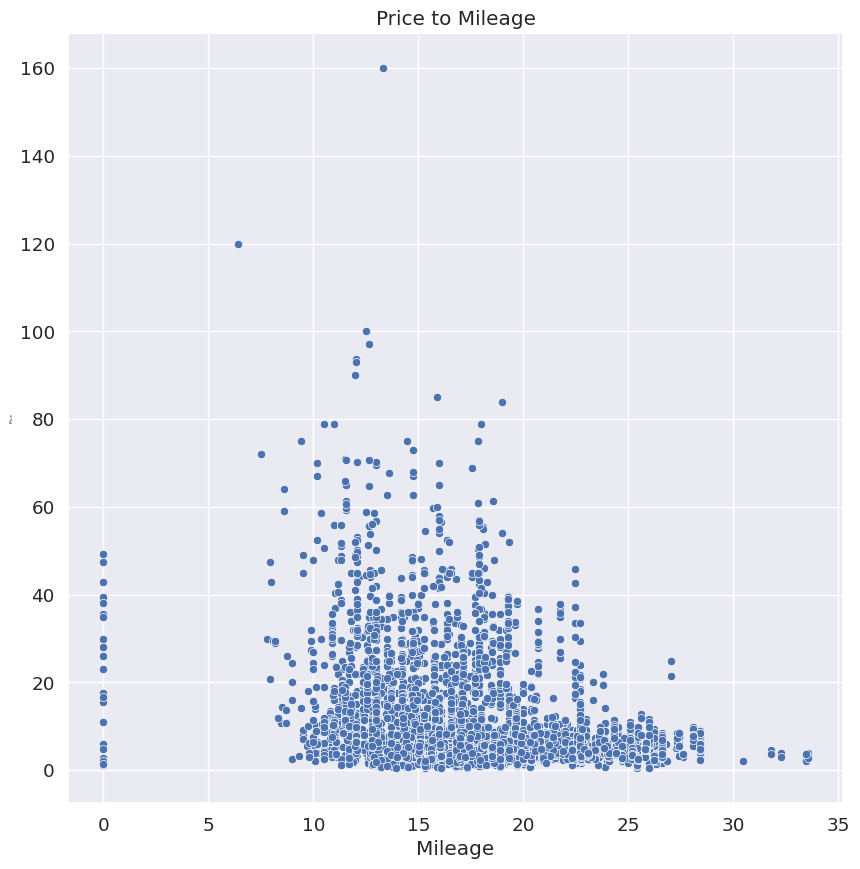

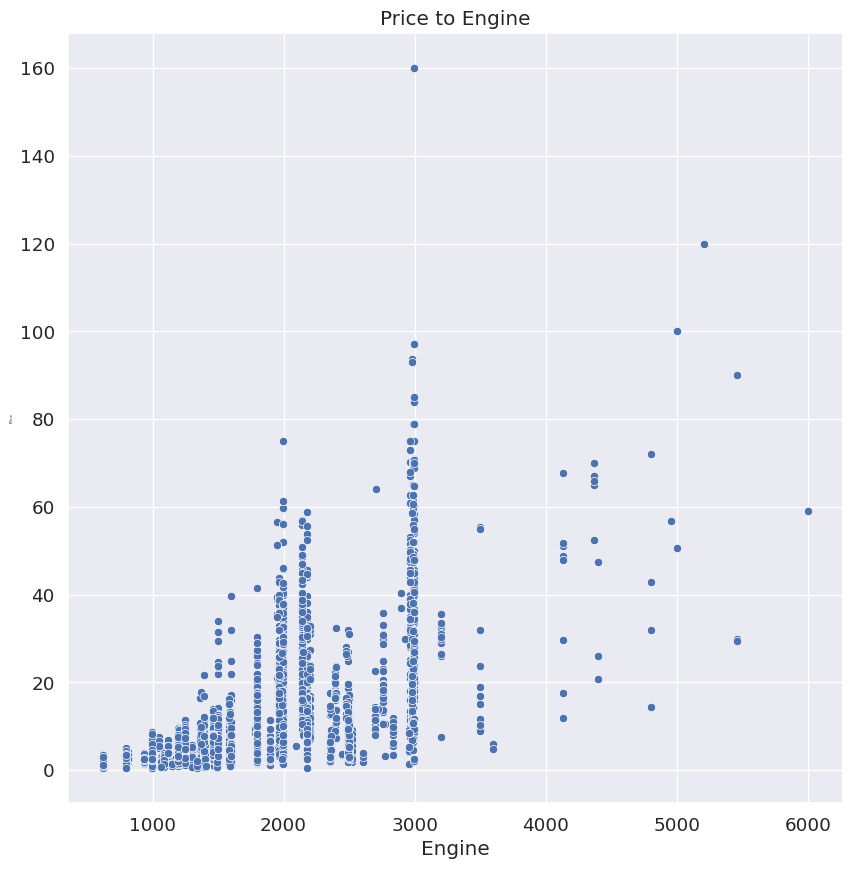

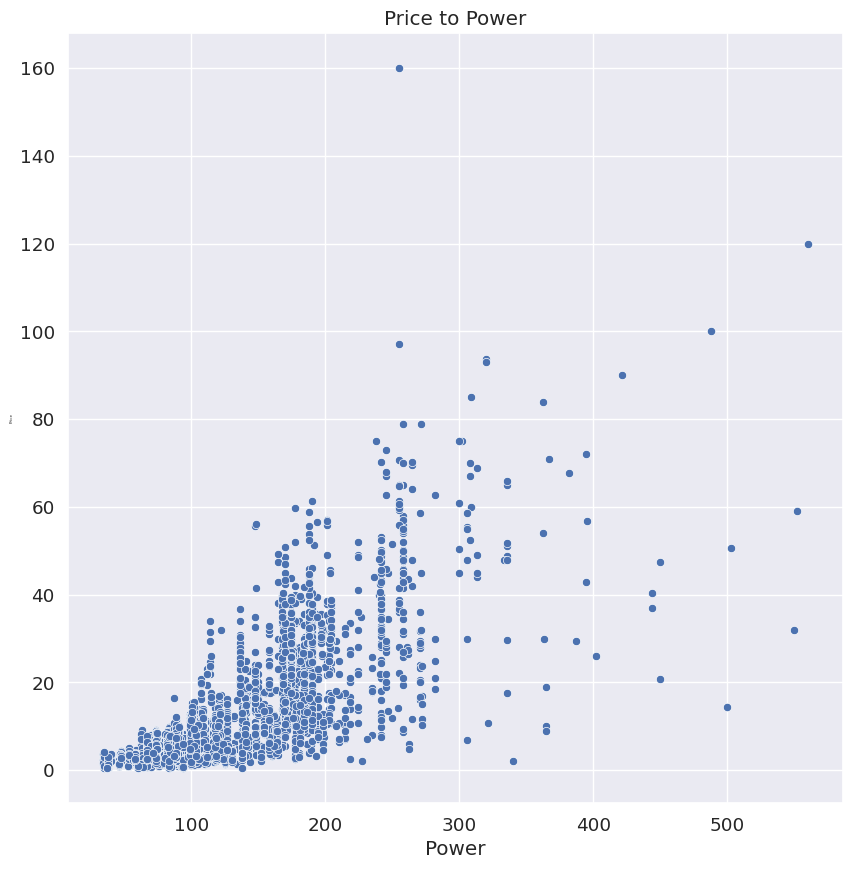

In [33]:
colums = ["Mileage","Engine","Power"]
for col in colums :
    plt.title(f"Price to {col}")
    sns.scatterplot(data = data , x=col ,y="Price")
    plt.xlabel(col)
    plt.ylabel("Price",fontsize=3)
    plt.show()

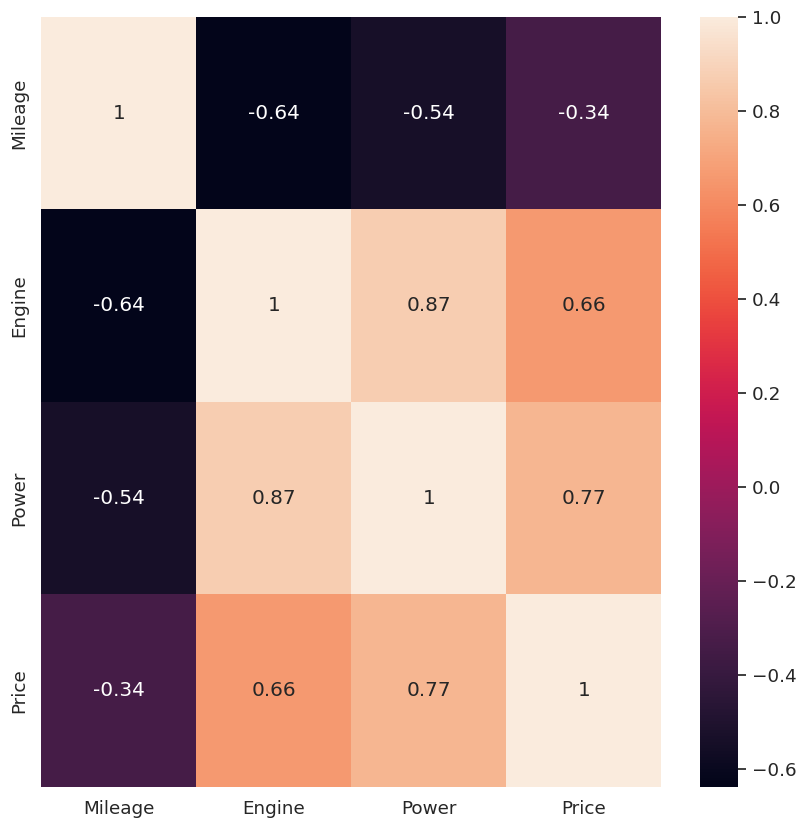

In [34]:
colums.append("Price")
first_corr_tabel = data[colums].corr()
sns.heatmap(first_corr_tabel,annot=True)
plt.show()

### The most expensive car?

In [35]:
data.iloc[data.Price.argmax()]["Name"]

'Land Rover'

> most expensive car is Land Rover

#### Best Selling Cars ?

In [36]:
data["Type"] = data.Name.apply(lambda x :x.split()[0])

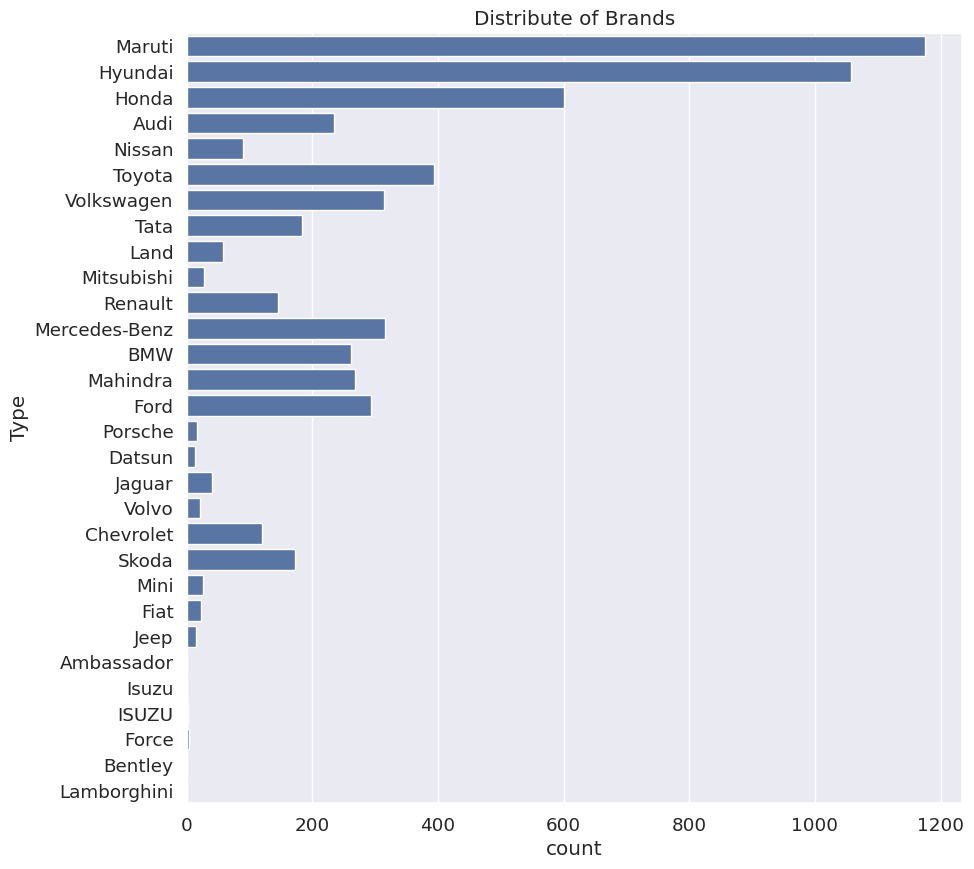

In [37]:
plt.figure(figsize=(10,10))
plt.title("Distribute of Brands")

sns.countplot(y=data.Type)
plt.show()


In [38]:
pd.DataFrame(data.Type.value_counts()[:5])

,count
Type,
Maruti,1175
Hyundai,1058
Honda,600
Toyota,394
Mercedes-Benz,316


#### Average car prices per type ?

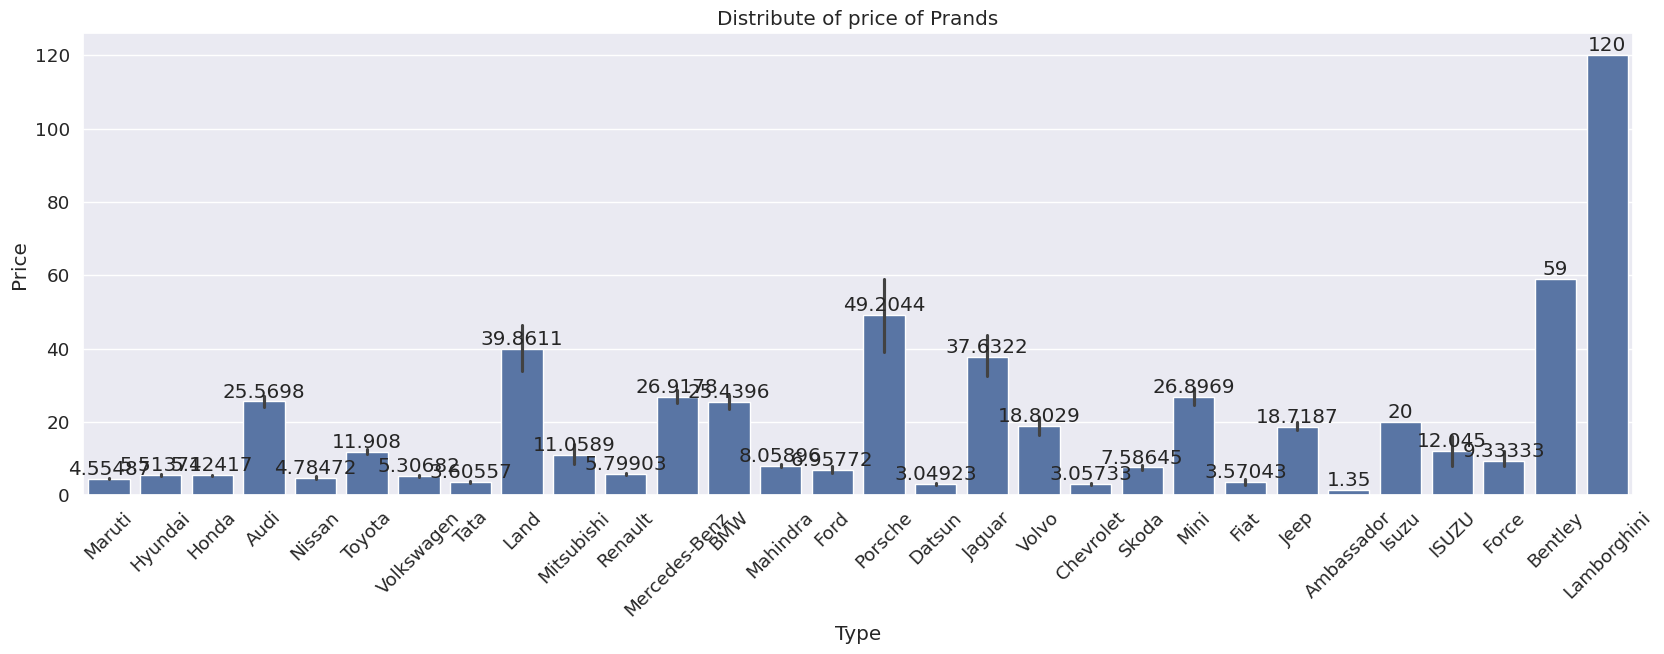

In [39]:
plt.figure(figsize=(20,6))
plt.title("Distribute of price of Prands")
figure = sns.barplot(data= data , x ="Type" ,y="Price")
for contain in figure.containers :
    figure.bar_label(contain)
plt.xticks(rotation=45)
plt.show()

In [40]:
pd.DataFrame(np.round(data.groupby("Type")["Price"].mean(),2).sort_values(ascending=False))


,Price
Type,
Lamborghini,120.0
Bentley,59.0
Porsche,49.2
Land,39.86
Jaguar,37.63
Mercedes-Benz,26.92
Mini,26.9
Audi,25.57
BMW,25.44


#### What kind of fuel do people prefer?

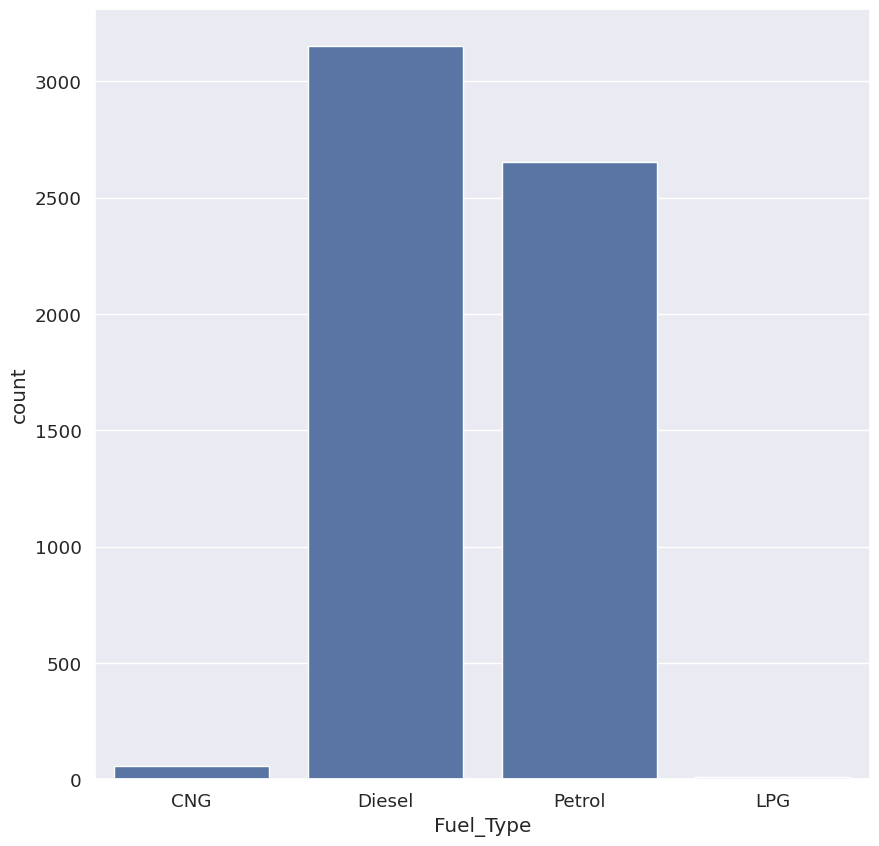

In [41]:
sns.countplot(data =data , x= "Fuel_Type")
plt.show()

In [42]:
pd.DataFrame(data.Fuel_Type.value_counts())

,count
Fuel_Type,
Diesel,3152
Petrol,2655
CNG,55
LPG,10


- people prefer Diesel and Petrol

#### Type of oldest car ?

In [43]:
data.iloc[data.Year.argmin()]["Name"]

'Maruti Zen'

- the oldest car is 'Maruti Zen'

In [44]:
data.sample()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Type
4841,BMW 3,Hyderabad,2011,89000,Diesel,Automatic,First,22.69,1995,190.0,5,13.95,BMW


#### The average price of cars relative to the location ?


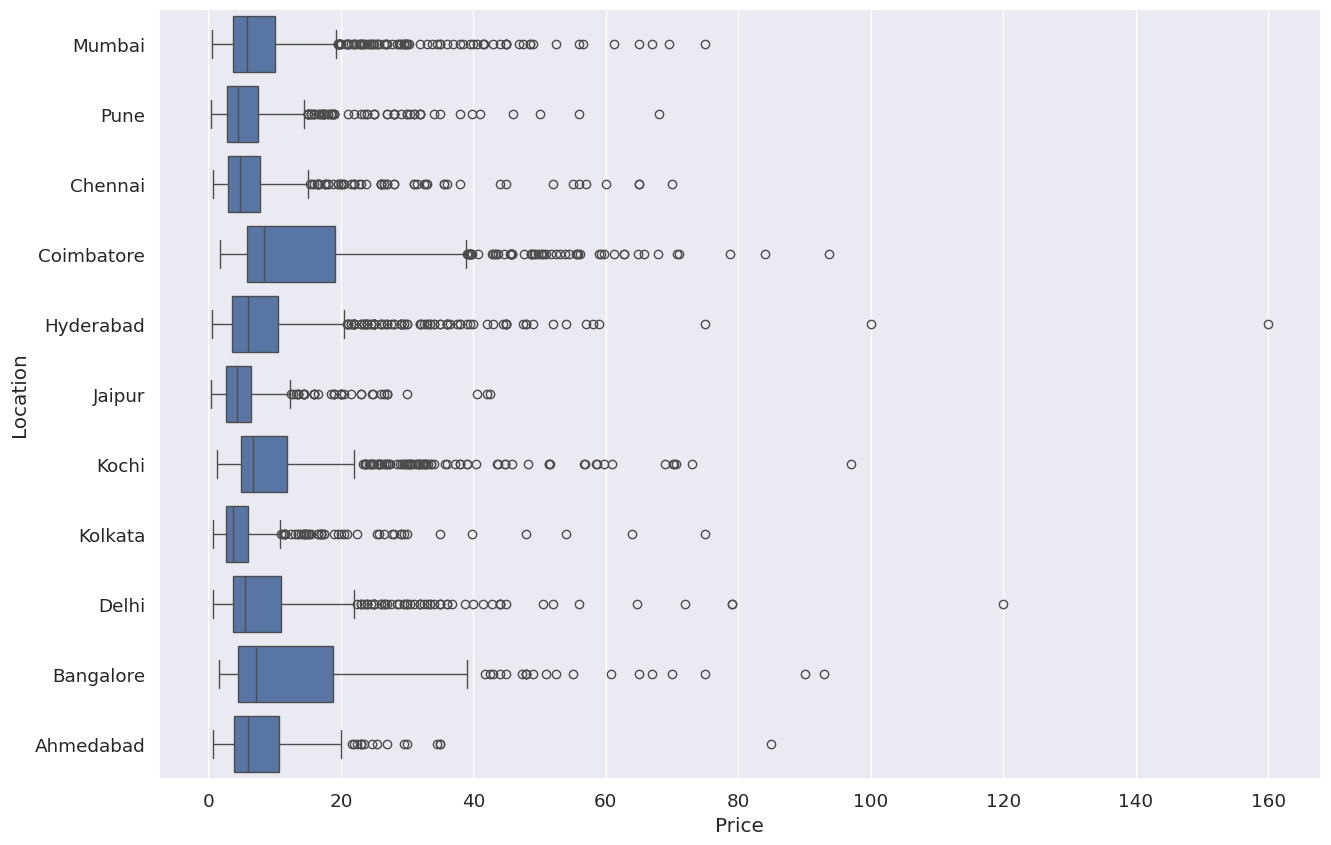

In [45]:
plt.figure(figsize=(15,10))
sns.boxplot(data= data ,x= "Price",y="Location")
plt.show()

In [46]:
pd.DataFrame(np.round(data.groupby("Location")["Price"].mean(),2).sort_values(ascending=False))


,Price
Location,
Coimbatore,15.14
Bangalore,13.64
Kochi,11.24
Hyderabad,9.91
Delhi,9.78
Mumbai,9.44
Ahmedabad,8.52
Chennai,7.94
Pune,6.9


#### The average price of each car type for each Location ?

In [47]:
pd.crosstab( index=data["Type" ],columns=  data["Location"],values=data.Price
            ,aggfunc=["mean"]).fillna(0)

mean                                              \
Location      Ahmedabad  Bangalore  Chennai    Coimbatore Delhi        
Type                                                                   
Ambassador           0.0        0.0       1.35        0.0        0.0   
Audi                14.6  28.448438  26.694444    32.5294  19.034074   
BMW            24.560667  29.829091  28.157407  30.785152     20.935   
Bentley              0.0        0.0        0.0        0.0        0.0   
Chevrolet          3.525   3.978571   2.410769   4.589091   2.036667   
Datsun               0.0       2.88       2.75       3.31        0.0   
Fiat                 0.0        0.0      2.375       5.67       1.65   
Force                0.0        0.0       12.0        0.0        0.0   
Ford            5.716667   4.786875   5.949778  10.850625   8.202941   
Honda           5.620385   5.770385   4.915429   7.058049      4.368   
Hyundai         5.792826   6.474231   4.809718   7.874586   5.122472   
ISUZU                0.0        0.0        0.0      16.09        0.0   
Isuzu                0.0        0.0        0.0        0.0        0.0   
Jaguar               0.0  27.316667       26.5  31.955714       44.3   
Jeep                 0.0        0.0        0.0      21.55        0.0   
Lamborghini          0.0        0.0        0.0        0.0      120.0   
Land                20.5       49.5       16.5     50.393  34.211538   
Mahindra            8.84   7.213158   5.440455  10.668421   8.116875   
Maruti             4.597   4.811429   4.409677    6.24043   4.460268   
Mercedes-Benz     25.702  30.257059  23.613636  40.857917  23.366176   
Mini                22.0       27.0       22.0      19.41       22.0   
Mitsubishi           0.0    14.3475       4.82     21.765      10.51   
Nissan             4.075        6.5   4.226923      6.244   3.196667   
Porsche              0.0       75.0        0.0  52.186667      61.25   
Renault           4.4875   7.413846      5.575   8.118571   5.599167   
Skoda           9.016667   7.694444   5.466667   9.673333   6.997222   
Tata            3.077778    4.07875   2.518095   4.875909   4.742857   
Toyota         12.642222  13.504737    9.96375  15.082162  11.682923   
Volkswagen      5.033333   5.055625   5.720789   7.225185   3.683333   
Volvo               16.0       21.0      9.625      24.36       16.0   

                                                                      \
Location      Hyderabad  Jaipur     Kochi      Kolkata    Mumbai       
Type                                                                   
Ambassador           0.0        0.0        0.0        0.0        0.0   
Audi           27.628966     16.375    26.7712  14.978125    24.0896   
BMW            24.273939      27.15    31.3836    15.0875  23.521224   
Bentley             59.0        0.0        0.0        0.0        0.0   
Chevrolet          4.055      2.395     3.7225   2.353889   3.020833   
Datsun              2.99        0.0       3.54      2.675        0.0   
Fiat                4.55     2.2375       5.85     2.5225      4.325   
Force                0.0        0.0        0.0        8.0        0.0   
Ford            6.702909       4.76  10.497241   4.716364   6.802353   
Honda           6.546596   4.750263   6.798642   4.134583   5.328148   
Hyundai         4.817228   4.494762   6.309708   3.829375   5.403063   
ISUZU                0.0        8.0        0.0        0.0        0.0   
Isuzu                0.0       20.0        0.0        0.0        0.0   
Jaguar            50.125        0.0       35.2  22.066667      43.65   
Jeep                16.9       19.5      18.01      16.25       18.4   
Lamborghini          0.0        0.0        0.0        0.0        0.0   
Land               44.47       16.5   48.89625        0.0    29.0625   
Mahindra         7.57963   8.125294   8.985294    7.21381   7.644483   
Maruti          4.579586   3.742544   5.888632   3.631875   4.500142   
Mercedes-Benz  24.521786  21.520833  25.561053   23.07125  

> note
- you can see that location Affects the price
  - example
      - Audi the distribute of car is more different in any Location
     
- you can find some car find in one Location
   - Ambassador in China
   - Lamborghini in Delhi
   - Jaguar

In [48]:
data.sample()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Type
4037,Honda City,Kochi,2017,38691,Petrol,Manual,First,17.8,1497,117.3,5,7.68,Honda


In [49]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

kilometers = data['Kilometers_Driven']
price = data['Price']

kilometers_reshaped = kilometers.values.reshape(-1, 1)

#
scaler = StandardScaler()

kilometers_scaled = scaler.fit_transform(kilometers_reshaped)

corr_coef, p_value = pearsonr(kilometers_scaled.flatten(), price)

# Output the results
print("Pearson correlation coefficient after scaling:", corr_coef)
print("P-value after scaling:", p_value)


Pearson correlation coefficient after scaling: -0.008248536278492296
P-value after scaling: 0.5274175411601776


> note
- there is a significant correlation between the standardized 'Number of Kilometers' and the 'Price' of the vehicles in the dataset.

<Axes: xlabel='Transmission', ylabel='count'>

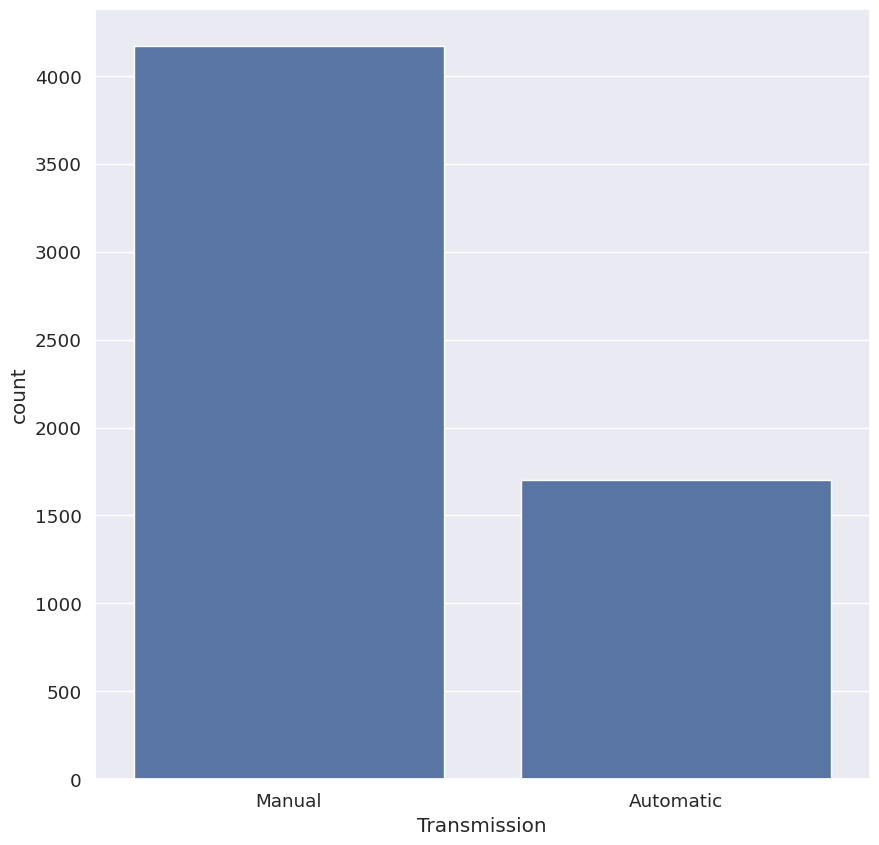

In [50]:
sns.countplot(x= data["Transmission"])

In [51]:
from scipy.stats import f_oneway


Transmission_groups = [data[data['Transmission'] == category]['Price'] for category in data['Transmission'].unique()]

# Perform ANOVA test
anova_result = f_oneway(*Transmission_groups)

# Output the ANOVA test result
print("ANOVA F-value:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)


ANOVA F-value: 3063.9283629348797
ANOVA p-value: 0.0


> note
- strong relationship between the transmission type and the price of cars.

> #### summary
- you can see the some simple Question and read the Result from nodes
  - if you have another Question at EDA you can write a comment

# Data PreProcessing

> #### Data Transformation

In [52]:
x = data.drop("Price" ,axis =1)
y= data["Price"]

In [53]:
nominal = ["Name" ,"Transmission","Location","Fuel_Type","Type"]
ordinal = ["Owner_Type"]
numerical = x.select_dtypes(["Int64","float64"]).columns

> #### numerical column

In [54]:
x[numerical]= StandardScaler().fit_transform(x[numerical])

In [55]:
x

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Type
0,Maruti Wagon,Mumbai,-1.099040,0.148468,CNG,Manual,First,1.906442,-1.043476,-1.023008,-0.352441,Maruti
1,Hyundai Creta,Pune,0.481089,-0.187898,Diesel,Manual,First,0.318916,-0.072717,0.239862,-0.352441,Hyundai
2,Honda Jazz,Chennai,-0.783014,-0.133646,Petrol,Manual,First,-0.017831,-0.709362,-0.456164,-0.352441,Honda
3,Maruti Ertiga,Chennai,-0.466988,0.311225,Diesel,Manual,First,0.570905,-0.627911,-0.455050,2.131992,Maruti
4,Audi A4,Coimbatore,-0.150963,-0.191479,Diesel,Automatic,Second,-0.705072,0.568916,0.510848,-0.352441,Audi
...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Maruti Swift,Delhi,0.165063,-0.335845,Diesel,Manual,First,2.318786,-0.627911,-0.729006,-0.352441,Maruti
6015,Hyundai Xcent,Jaipur,0.481089,0.452282,Diesel,Manual,First,1.402465,-0.840681,-0.784688,-0.352441,Hyundai
6016,Mahindra Xylo,Jaipur,-0.466988,-0.035991,Diesel,Manual,Second,-0.979968,1.449914,-0.023700,3.374208,Mahindra
6017,Maruti Wagon,Kolkata,-0.150963,-0.133646,Petrol,Manual,First,0.142525,-1.043476,-0.857075,-0.352441,Maruti


> #### ordial column

In [56]:
transformation = {
    "First":3,
    "Second":2,
    "Third":1,
    "Fourth & Above":0
}

x["Owner_Type"] = x["Owner_Type"].map(transformation)

In [58]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.4 MB/s eta 0:00:00


> #### nominal column

In [59]:
import category_encoders as ce
binaryencoder = ce.BinaryEncoder(cols=nominal)
binaryencoder.fit(x)


BinaryEncoder(cols=['Name', 'Transmission', 'Location', 'Fuel_Type', 'Type'],
              mapping=[{'col': 'Name',
                        'mapping':       Name_0  Name_1  Name_2  Name_3  Name_4  Name_5  Name_6  Name_7
 1         0       0       0       0       0       0       0       1
 2         0       0       0       0       0       0       1       0
 3         0       0       0       0       0       0       1       1
 4         0       0       0       0       0       1       0       0
 5         0       0       0       0       0       1       0       1
...      ...     ...     ...     ...     ...     ...     ...     ...
 205       1       1       0       0       1       1       0       1
 206       1       1       0       0       1       1       1       0
 207       1       1       0       0       1       1       1       1
-1         0       0       0       0       0       0       0       0
-2         0       0       0       0       0       0       0       0

[209 rows x 8 columns]},
                       {'col': 'Transmission',
                        'mapping':     Transmission_0  Trans...
                       {'col': 'Fuel_Type',
                        'mapping':     Fuel_Type_0  Fuel_Type_1  Fuel_Type_2
 1            0            0            1
 2            0            1            0
 3            0            1            1
 4            1            0            0
-1            0            0            0
-2            0            0            0},
                       {'col': 'Type',
                        'mapping':      Type_0  Type_1  Type_2  Type_3  Type_4
 1        0       0       0       0       1
 2        0       0       0       1       0
 3        0       0       0       1       1
 4        0       0       1       0       0
 5        0       0       1       0       1
 6        0       0       1       1       0
 7        0       0       1       1       1
 8        0       1       0       0       0
 9        0       1       0       0       1
 10       0       1       0       1       0
 11       0       1       0       1       1
 12       0       1       1       0       0
 13       0       1       1       0       1
 14       0       1       1       1       0
 15       0       1       1       1       1
 16       1       0       0       0       0
 17       1       0       0       0       1
 18       1       0       0       1       0
 19       1       0       0       1       1
 20       1       0       1       0       0
 21       1       0       1       0       1
 22       1       0       1       1       0
 23       1       0       1       1       1
 24       1       1       0       0       0
 25       1       1       0       0       1
 26       1       1       0       1       0
 27       1       1       0       1       1
 28       1       1       1       0       0
 29       1       1       1       0       1
 30       1       1       1       1       0
-1        0       0       0       0       0
-2        0       0       0       0       0}])

In [60]:
x = binaryencoder.transform(x)


In [61]:
x

,Name_0,Name_1,Name_2,Name_3,Name_4,Name_5,Name_6,Name_7,Location_0,Location_1,...,Owner_Type,Mileage,Engine,Power,Seats,Type_0,Type_1,Type_2,Type_3,Type_4
0,0,0,0,0,0,0,0,1,0,0,...,3,1.906442,-1.043476,-1.023008,-0.352441,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,3,0.318916,-0.072717,0.239862,-0.352441,0,0,0,1,0
2,0,0,0,0,0,0,1,1,0,0,...,3,-0.017831,-0.709362,-0.456164,-0.352441,0,0,0,1,1
3,0,0,0,0,0,1,0,0,0,0,...,3,0.570905,-0.627911,-0.455050,2.131992,0,0,0,0,1
4,0,0,0,0,0,1,0,1,0,1,...,2,-0.705072,0.568916,0.510848,-0.352441,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,0,0,0,0,1,1,0,1,1,0,...,3,2.318786,-0.627911,-0.729006,-0.352441,0,0,0,0,1
6015,0,0,1,0,0,0,0,1,0,1,...,3,1.402465,-0.840681,-0.784688,-0.352441,0,0,0,1,0
6016,1,0,0,0,1,0,0,0,0,1,...,2,-0.979968,1.449914,-0.023700,3.374208,0,1,1,1,0
6017,0,0,0,0,0,0,0,1,1,0,...,3,0.142525,-1.043476,-0.857075,-0.352441,0,0,0,0,1


> ## Split Data

In [62]:
x_train ,x_test ,y_train ,y_test =train_test_split(x,y,random_state=42 ,shuffle=True ,test_size=.2)

In [63]:
print(x_train.shape)

(4697, 29)


# Modeling

In [64]:
model = LinearRegression()
model.fit(x_train ,y_train)

y_train_predict = model.predict(x_train)

print('acc of train' , r2_score(y_train,y_train_predict))


y_test_predict = model.predict(x_test)

print('acc of test' , r2_score(y_test,y_test_predict))

acc of train 0.7244526052423219
acc of test 0.6932226070953733


In [65]:
model = LinearRegression()
model.fit(x_train ,np.log(y_train))

y_train_predict = model.predict(x_train)

print('acc of train' , r2_score(np.log(y_train),y_train_predict))


y_test_predict = model.predict(x_test)

print('acc of test' , r2_score(np.log(y_test)
                               ,y_test_predict))

acc of train 0.8868199038514647
acc of test 0.8688389930336843


In [66]:
model = DecisionTreeRegressor(max_depth=6)
model.fit(x_train ,np.log(y_train))

y_train_predict = model.predict(x_train)

print('acc of train' , r2_score(np.log(y_train),y_train_predict))


y_test_predict = model.predict(x_test)

print('acc of test' , r2_score(np.log(y_test)
                               ,y_test_predict))

acc of train 0.8964820223191977
acc of test 0.8519980396713066


In [67]:
model = DecisionTreeRegressor(max_depth=6,max_leaf_nodes=42)
model.fit(x_train ,np.log(y_train))

y_train_predict = model.predict(x_train)

print('acc of train' , r2_score(np.log(y_train),y_train_predict))


y_test_predict = model.predict(x_test)

print('acc of test' , r2_score(np.log(y_test)
                               ,y_test_predict))

acc of train 0.8843212689248328
acc of test 0.8504341230010803


In [68]:
model = DecisionTreeRegressor(max_depth=6,max_leaf_nodes=42,max_features=50)
model.fit(x_train ,np.log(y_train))

y_train_predict = model.predict(x_train)

print('acc of train' , r2_score(np.log(y_train),y_train_predict))


y_test_predict = model.predict(x_test)

print('acc of test' , r2_score(np.log(y_test)
                               ,y_test_predict))

acc of train 0.8843212689248328
acc of test 0.8504341230010803


In [69]:
model = RandomForestRegressor(n_estimators=100 , max_depth=6,max_leaf_nodes=42,max_features=50)
model.fit(x_train ,np.log(y_train))

y_train_predict = model.predict(x_train)

print('acc of train' , r2_score(np.log(y_train),y_train_predict))


y_test_predict = model.predict(x_test)

print('acc of test' , r2_score(np.log(y_test)
                               ,y_test_predict))

acc of train 0.9094800269807992
acc of test 0.8786659714420345


In [70]:
model = XGBRegressor(n_estimators=60 , max_depth=4)
model.fit(x_train ,np.log(y_train))

y_train_predict = model.predict(x_train)

print('acc of train' , r2_score(np.log(y_train),y_train_predict))


y_test_predict = model.predict(x_test)

print('acc of test' , r2_score(np.log(y_test)
                               ,y_test_predict))

acc of train 0.9690554557032799
acc of test 0.9345017853380554


> # `Thank you"